# Navigation par corrélation de terrain

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy import random
from numpy.random import multinomial
import numpy.linalg
import math
from scipy import interpolate

dict_keys(['__header__', '__version__', '__globals__', 'ans', 'dt_resol', 'h_MNT', 'i', 'j', 'lat_reel', 'rayon', 'resol_ang', 'x_MNT', 'y_MNT'])
(1, 799)


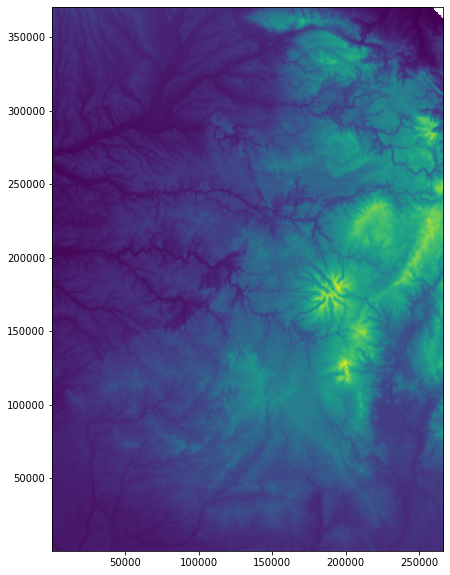

In [2]:
data = loadmat('carte_centreMetres.mat');
print(data.keys())
h_mnt = data["h_MNT"]
h_mnt = np.flip(h_mnt,axis = 0)
x_mnt = data["x_MNT"]
y_mnt = data["y_MNT"]
print(np.shape(x_mnt))
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])

In [84]:
def redistribution(X,w):
    w_normalise = w/np.sum(w)
    shape = np.shape(X)
    n = shape[0]
    multinom = multinomial(n,w_normalise)
    X_redistribue = []
    for i in range(n):
        for j in range(multinom[i]):
            X_redistribue.append(X[i]) 
    X_redistribue = np.array(X_redistribue)
    return(X_redistribue)

In [4]:
def reechantillonage(X_redistribue,h):
    shape = np.shape(X_redistribue)
    n = shape[0]
    p = shape[1]
    X_reechant = np.zeros((n,p))
    cov = np.cov(X_redistribue.T)
    gamma = np.linalg.cholesky(cov)
    for i in range(n):
        X_reechant[i]= X_redistribue[i] + h*np.dot(gamma,np.random.normal(0,1,p))
    return(X_reechant)

### Constantes

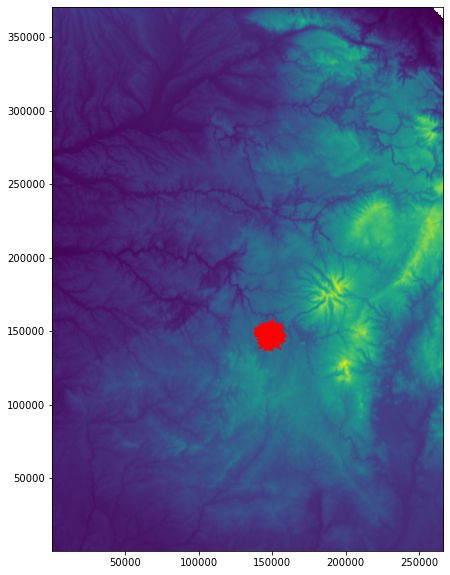

In [38]:
# constantes
dt = 1
phi = np.identity(6)
for i in range(3):
    phi[i,i+3]=dt
incertitude_x = 3000
incertitude_y = 3000
incertitude_z = 500
incertitude_vitesse = 5
vitavion = 300*1000/3600
capavion = 45*math.pi/180
X0_vrai =np.array([150*1000,150*1000,8000,vitavion*math.cos(capavion),vitavion*math.sin(capavion),0])
sigma_bruit =30
array_incertitude = np.array([incertitude_x,incertitude_y,incertitude_z,incertitude_vitesse,incertitude_vitesse,incertitude_vitesse])
P0 = np.diag(array_incertitude)
racine_P0 = np.sqrt(P0)
pseudoX0 = X0_vrai+2*np.array([np.random.uniform(0,incertitude) for incertitude in array_incertitude])- array_incertitude
N_part = 5000
particules_0 = np.array([pseudoX0+ np.dot(P0,np.random.normal(0,1,6)) for i in range(N_part)])
T=720
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])
plt.plot(particules_0[:,0],particules_0[:,1],'r')


In [39]:
def dynamique(X0,phi,T):
    n,= np.shape(X0)
    X = np.zeros((T,n))
    X[0]=X0
    for i in range(1,T):
        X[i]=np.dot(phi,X[i-1])
    return(X)    

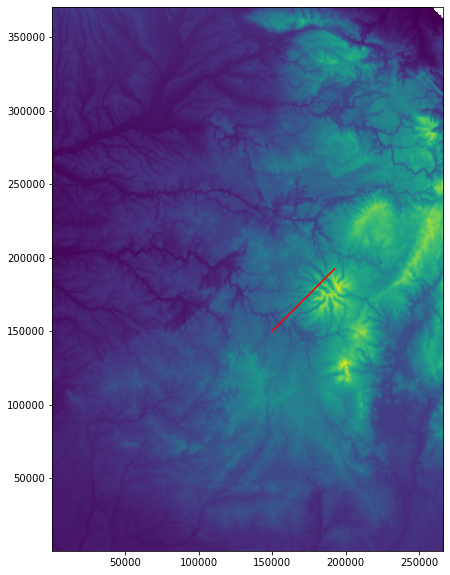

In [55]:
trajectoire = dynamique(X0_vrai,phi,T)
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])
plt.plot(trajectoire[:,0],trajectoire[:,1],'r')

In [112]:
def mesure_bruitee(trajectoire,sigma_bruit):
    n,p = np.shape(trajectoire)
    mes = np.zeros(n)
    for i in range(n):
        mes[i]= mesure(trajectoire[i,0],trajectoire[i,1],trajectoire[i,2])+np.random.normal(0,sigma_bruit)
    return(mes)

def mesure(x,y,z):
    delta_x =x_mnt[0,-1]-x_mnt[0,0]
    delta_y = y_mnt[0,-1]-y_mnt[0,0]
    indice_x = (x-x_mnt[0,0])*799/(delta_x)
    indice_y = (y-y_mnt[0,0])*799/(delta_y)
    return(z-h_mnt[max(0,min(int(indice_x),798)),max(0,min(int(indice_y),798))])

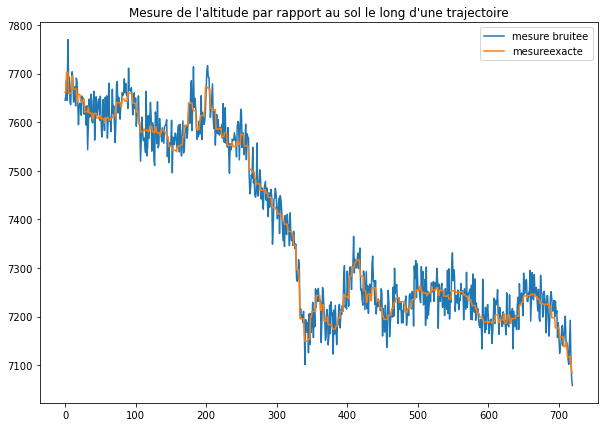

In [56]:
mesure_bruitees_traj = mesure_bruitee(trajectoire,sigma_bruit)
mesure_exactes = np.array([mesure(etat[0],etat[1],etat[2]) for etat in trajectoire])
plt.figure(figsize=(10,7))
plt.plot(mesure_bruitees_traj)
plt.plot(mesure_exactes)
plt.title("Mesure de l'altitude par rapport au sol le long d'une trajectoire")
plt.legend(['mesure bruitee','mesureexacte'])

### iterpolation

In [329]:
absc = np.arange(0,799,1)
ord = np.arange(0,799,1) 
modele_interpole = interpolate.interp2d(absc,ord,h_mnt,kind = 'cubic')
modele_interpole(500,500)

array([nan])

### filtrage particulaire

In [103]:
def vraissemblance(etat,observation):
    return(noyeau_gaussien(observation-mesure(etat[0],etat[1],etat[2])))

def noyeau_gaussien(x):
    return(np.exp((-x**2)/(2*(sigma_bruit**2)))/np.sqrt(2*math.pi*sigma_bruit))

def filtrage_particulaire(particules_0,mesure_traj,N_th,phi,T,h):
    n,p = np.shape(trajectoire)
    N_part,p_part = np.shape(particules_0)
    particules = np.zeros((T,N_part,p))
    particules[0]= particules_0
    weights = np.ones(N_part)/N_part
    particules_temp = np.zeros((N_part,p))
    for i in range(1,T):
        #evolution/prediction
        particules_temp = np.zeros((N_part,p))
        for j in range(N_part):
            particules_temp[j] = np.dot(phi,particules[i-1,j])
            #correction
            weights[j]=vraissemblance(particules_temp[j],mesure_traj[i])
        weights = weights/np.sum(weights)
        X_redistribue = redistribution(particules_temp,weights)
        critère = 1/np.sum(weights**2)
        if critère <=N_th:
            X_redistribue = reechantillonage(X_redistribue,h)
        particules[i]=X_redistribue
    return(particules)


In [104]:
h_opt = (4/3)**(1/5)*N_part**(-1/5)
print(h_opt)

0.19283850080052542


In [113]:
particules = filtrage_particulaire(particules_0, mesure_bruitees_traj, 2*N_part,phi,T,h=h_opt)

IndexError: index -802 is out of bounds for axis 1 with size 799

In [107]:
with open('particules.npy','wb') as f : 
    np.save(f,particules)
with open('trajectoire.npy','wb') as f : 
    np.save(f,trajectoire)

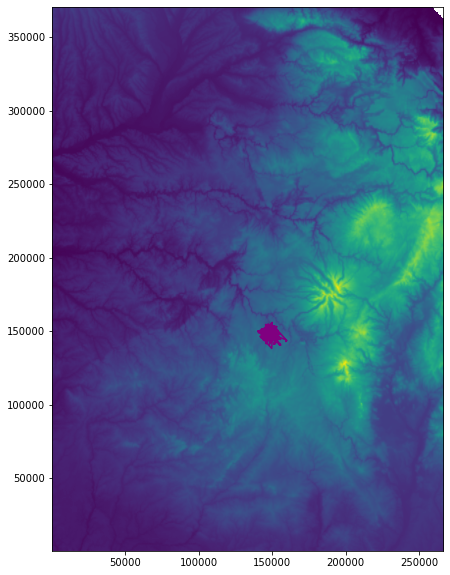

In [98]:
plt.figure(figsize = (10,10))
plt.imshow(h_mnt,extent = [x_mnt[0,0],x_mnt[0,-1],y_mnt[0,0],y_mnt[0,-1]])
plt.plot(particules[10,:,0],particules[10,:,1],'purple')